## Drifters and Cmems data Notebook

### Introduction
This notebook aims to interpolate the wind field from CMEMS onto the drifter positions and calculate the surface Ekman current, and then add it to the geostrophic current.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047

### Tasks

#### 1. Interpolation and Ekman current

- Interpolating the wind field from CMEMS onto the drifter positions and calculating the surface Ekman current.

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (DUACS current) and conclusion.
-  Adding the inertial current to the geostrophic current (DUACS current) and conclusion.

#### 1. Interpolation and Ekman current

## Import Library

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data

In [2]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables

In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data

In [5]:
# Test: Our selected drifter has 1102 observations. 

df_1 = df[0:500]
df_1

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
495,-22.450,-17.101,2023-05-04 18:00:00,0.02080,0.00505,26.874
496,-22.443,-17.101,2023-05-05 00:00:00,0.03049,0.02243,26.792
497,-22.437,-17.092,2023-05-05 06:00:00,0.02100,0.03648,26.749
498,-22.435,-17.087,2023-05-05 12:00:00,-0.00296,0.03702,26.820


## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity ugosa and  vgosa

In [6]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude' et 'longitude' 

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1713524113026.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'ugosa' et 'vgosa'

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

### Case of east-West and North-South Component of 10m Surface Wind(u_mean) and (v_mean)

In [7]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude' et 'longitude' 

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('erdlasFnWind10_LonPM180_f502_71d8_5228.nc')   
# Supposez que vos données satellitaires de vent sont stockées dans une variable appelée 'u_mean' et 'v_mean'

# Extraction des données de vent satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_vent_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['u_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_vent_u.append(courant)

satellitaires_vent_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['v_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_vent_v.append(courant)

### Case of East-West and North-South Component of 10m Wind Stress (taux_mean and tauy_mean) plus magnitude uv_mag_mean

In [8]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude' et 'longitude' 

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('erdlasFnWind20_LonPM180_f502_71d8_5228.nc')   
# Supposez que vos données satellitaires de stress du vent sont stockées dans une variable appelée 'taux_mean' et ''tauy_mean'

# Extraction des données de stress de vent satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_taux = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['taux_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_taux.append(courant)

satellitaires_tauy = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['tauy_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_tauy.append(courant)

## Calculation of surface Ekman current

## Calculation of Ekman current:

The speed of Ekman current can be calculated using the Ekman equation:
$$
V_{Ek} = \frac{{1}}{{\rho fH}} \cdot \nabla \times \tau 
$$
Where:
- $ V_{Ek}$ is the Ekman current.
- $ \tau $ is the wind stress, which is the force exerted by the wind on the water surface.
- $ \rho $ is the water density.
- $ f $ is the Coriolis parameter, which depends on latitude.

The formula for wind stress can be expressed as follows:

$$ \tau = \rho_a \cdot C_d \cdot \| \text{V} \| \cdot \text{V} $$

where :

- $\rho_a$ is the air density (in $ \text{kg/m}^3 $),
- $ C_d $ is the drag coefficient (dimensionless),
- $\| \text{V} \|$ is the magnitude of the wind velocity vector (in $ \text{m/s} $),
- $\text{V} $ is the wind velocity vector,
- $\tau$ is in $N/m^{2}$

In [9]:
# Calculate wind shear components tau_x and tau_y
H = 15  # Profondeur de la couche d'Ekman
rho = 1025   # Masse volumique de l'eau (kg/m^3)  

# Calculate the Coriolis parameter f based on latitudes
f = 2 * np.pi * 7.29e-5 * np.sin(np.deg2rad(latitudes))

# Calculate Ekman current components
u_e_sat =  satellitaires_tauy / (f*rho*H)
v_e_sat =  satellitaires_taux / (-f*rho*H)

# Display results
#print("Component x of Ekman current (u_e):", u_e_sat)
#print("Component y of Ekman current (v_e):", v_e_sat)

## Calculation the inertial current

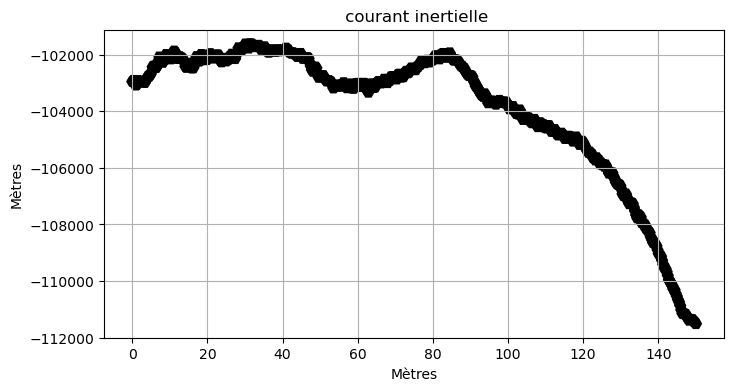

In [10]:
### déclaration des paramètres et des variables 
T_0= 1
# Av=10^(-3);    ## Coefficient de viscosité en m2/s
# rhozero=1025;  ## masse volumique en kg/m3
# tauxzero=1;    ## en N/m2
f = 2 * np.pi * 7.29e-5 * np.sin(np.deg2rad(df_1['latitude']));     ## paramètre de coriolis en 1/s
t=np.linspace(0, 10, 500); ## définition de l’echelle de nos axes 

#### partir réservée au calcul %%%%%%%
H=15; ## profondeur d'Ekman
U =  T_0*np.cos(f*t) / H
V = -T_0*np.sin(f*t) / H
longitude = T_0*np.sin(f*t) / f*H
latitude = T_0*np.cos(f*t) / f*H

#### Visualisation du courant inertiel ####
# Tracé des vecteurs avec quiver
plt.figure(figsize=(8, 4))
plt.quiver(longitude,latitude, U, V, scale=(150), width=0.02)
plt.xlabel('Mètres')
plt.ylabel('Mètres')
plt.grid(True)
plt.title(' courant inertielle')
plt.savefig("fig21 mode.png")

#### 2. Adding the surface Ekman and inertial current to the geostrophic current.
-  Adding the surface Ekman and inertial current to the geostrophic current (CMEMS current) and conclusion.

## ugosa plus Ekman zonal current

In [11]:
# u_total = u_geostro + u_e_sat
u_total = satellitaires_courant_u + u_e_sat + U

## v_current plus Ekman meridional current

In [12]:
# u_total = v_geostro + v_e_sat
v_total = satellitaires_courant_v + v_e_sat + V

## Creation of Pandas Array for CMEMS total current Data

In [13]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF

,u_total,v_total
0,-0.014593,-0.041217
1,-0.013985,-0.039104
2,-0.016897,-0.038031
3,-0.021219,-0.035506
4,-0.021701,-0.031562
...,...,...
495,0.094598,-0.017743
496,0.094302,-0.018883
497,0.093494,-0.019935
498,0.093024,-0.020761


## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between ve and u_total of CMEMS

## Using Regression and Correlation

Corrélation de Pearson: 0.5348990656554423
Valeur de p (p-value): 2.3758881984528274e-38


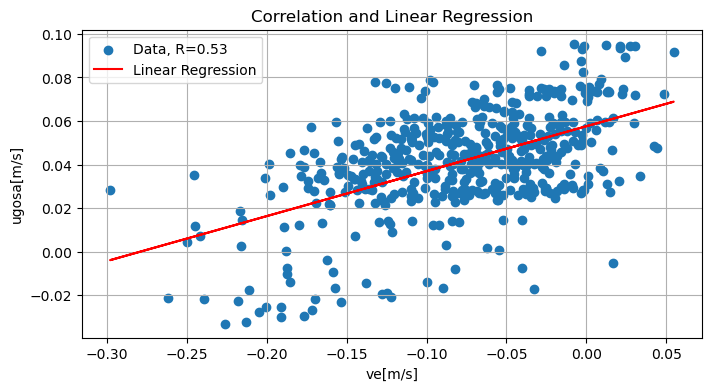

In [14]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.53. 
# This means that there is a general tendency for the values of the variables to increase together, but this relationship is not very strong.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = df_1['ve']
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve[m/s]')
plt.ylabel('ugosa[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
# plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

### The use of Kalman filter for smoothing $v_e$ and $u_total$

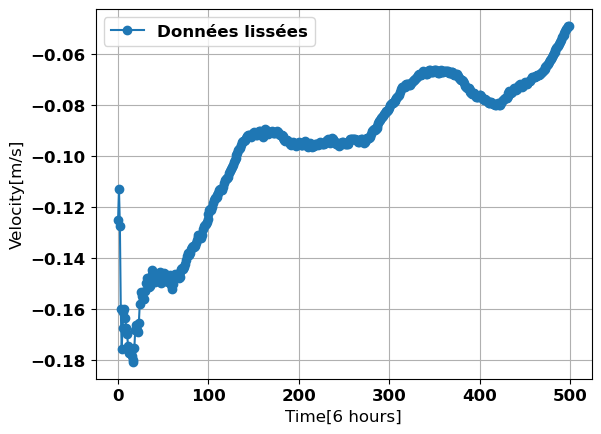

In [15]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = bouees_courant_u

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_1 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_1.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_1, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $u_total$

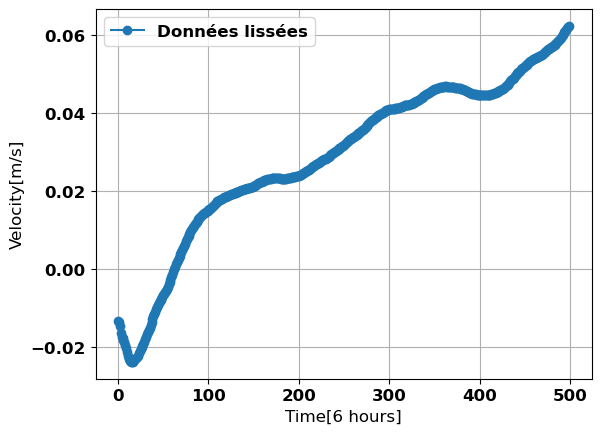

In [16]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = dF['u_total']

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_2 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_2.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_2, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

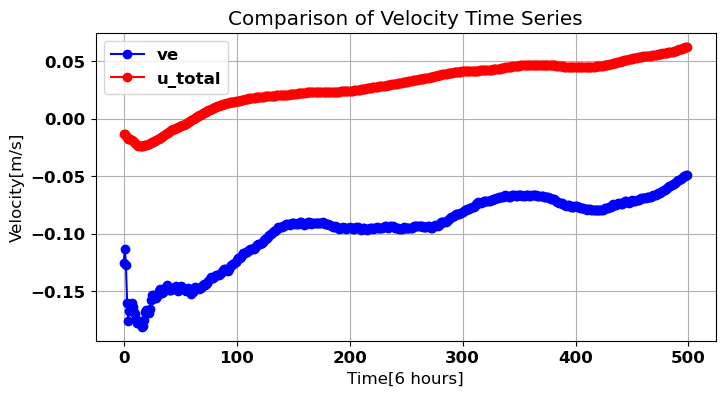

In [44]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(filtered_values_2, color='RED', marker='o', linestyle='-', label='u_total')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
#plt.savefig("fig12 mode.png")
# Show plot
plt.show()

## Comparison between vn and v_total of CMEMS

## Using Regression and Correlation

Corrélation de Pearson: 0.21732688525718016
Valeur de p (p-value): 9.287038858458701e-07


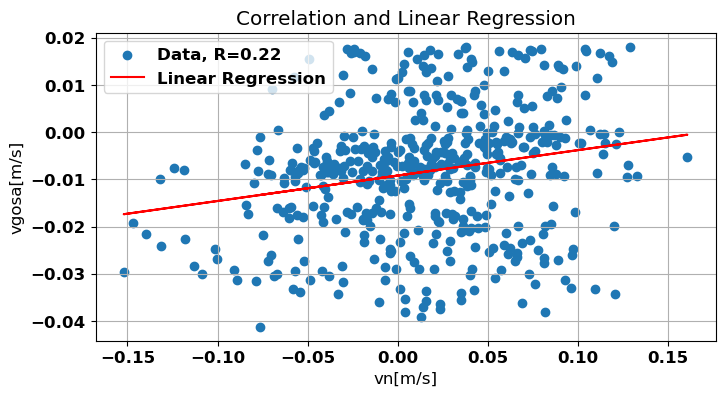

In [17]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.22. 
# This means that there is a general tendency for the values of the variables to increase together, but this relationship is not very strong.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = df_1['vn']
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn[m/s]')
plt.ylabel('vgosa[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
# plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

### The use of Kalman filter for smoothing $v_n$ and $v_total$

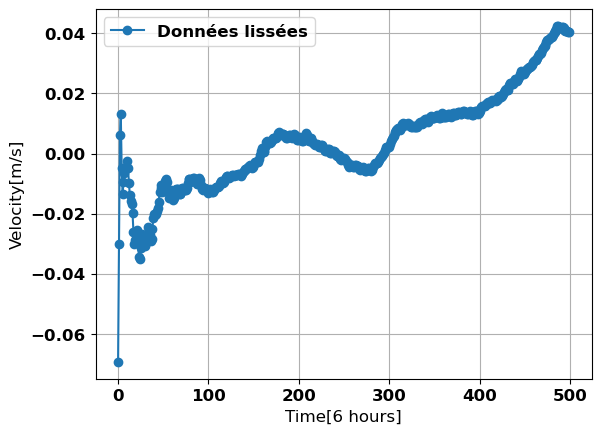

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = bouees_courant_v

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_3 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_3.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_3, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $v_total$

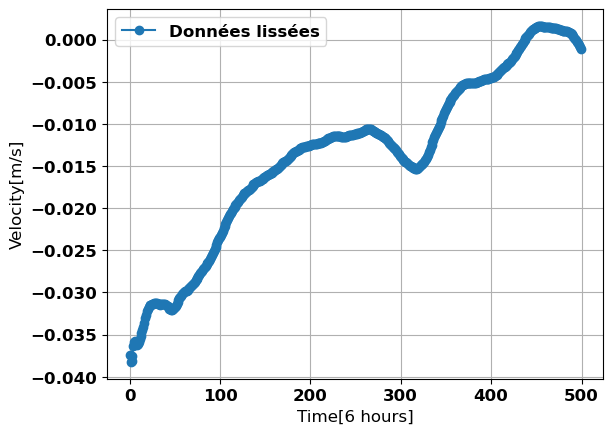

In [19]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = dF['v_total']

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_4 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_4.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_4, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

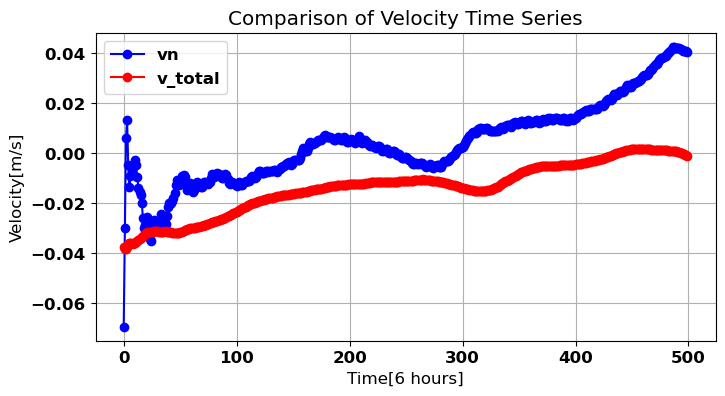

In [20]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(filtered_values_4, color='RED', marker='o', linestyle='-', label='v_total')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
#plt.savefig("fig12 mode.png")
# Show plot
plt.show()

### The use of Kalman filter for smoothing $ugosa$ and $vgosa$

### Case of ugosa 

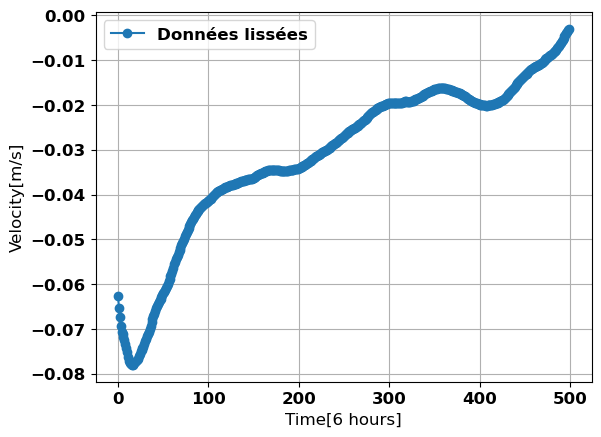

In [21]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  satellitaires_courant_u

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_5 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_5.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_5, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of vgosa 

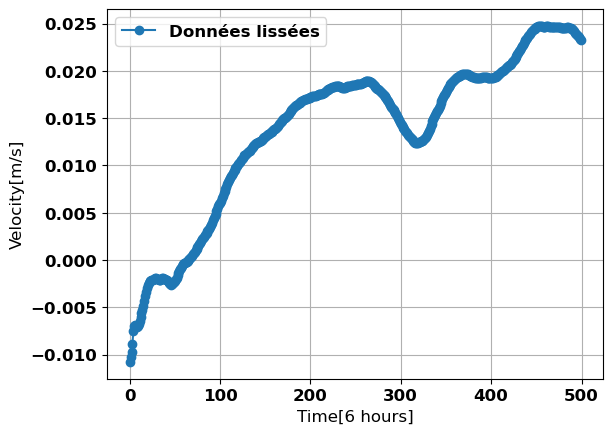

In [22]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  satellitaires_courant_v

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_6 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_6.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_6, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of u_e_sat (u_ekman)

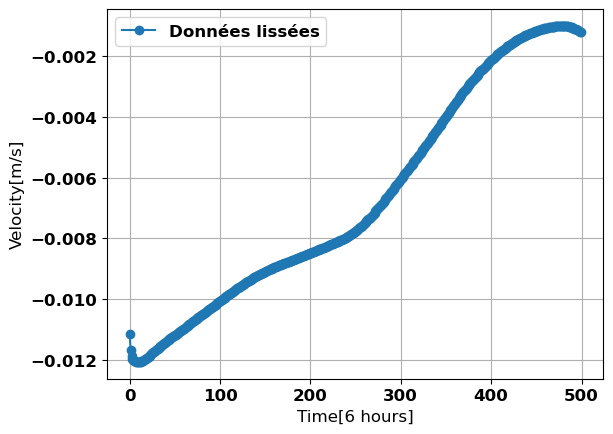

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  u_e_sat

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_7 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_7.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_7, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of v_e_sat (v_ekman)

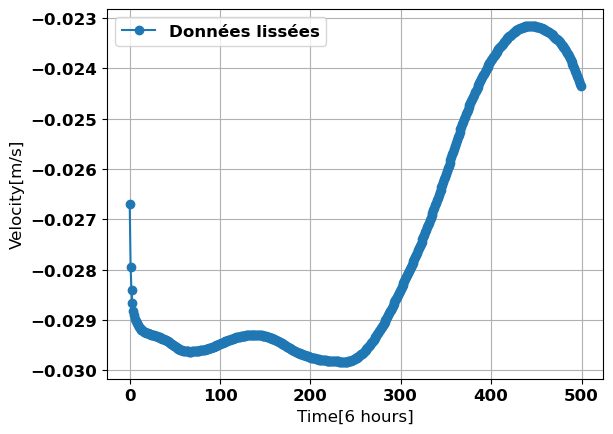

In [24]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  v_e_sat

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_8 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_8.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_8, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of U (U_inertial)

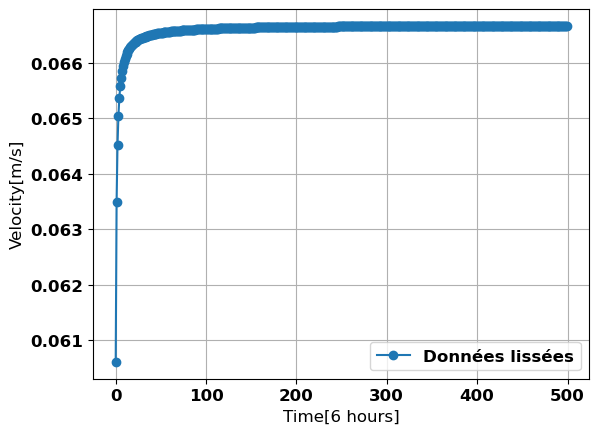

In [25]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  U

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_9 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_9.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_9, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of V (V_inertial)

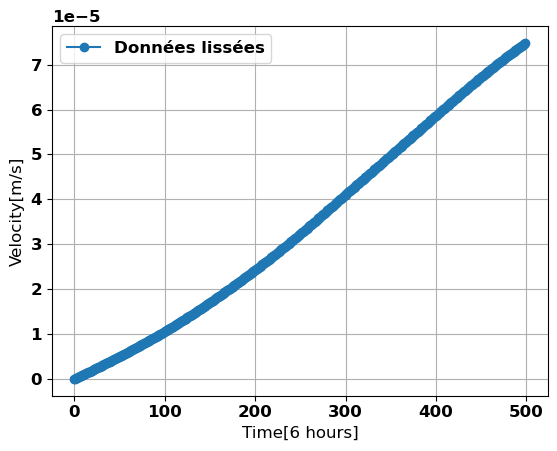

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  V

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_10 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_10.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_10, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Resume

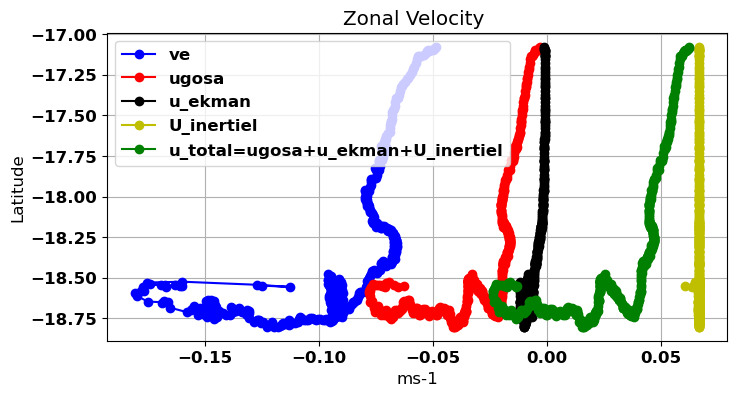

In [27]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1, df_1['latitude'],marker='o', linestyle='-', color='blue',label='ve')
plt.plot(filtered_values_5, df_1['latitude'],marker='o', linestyle='-', color='red',label='ugosa')
plt.plot(filtered_values_7, df_1['latitude'],marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(filtered_values_9, df_1['latitude'],marker='o', linestyle='-', color='y',label='U_inertiel')
plt.plot(filtered_values_2, df_1['latitude'],marker='o', linestyle='-', color='g',label='u_total=ugosa+u_ekman+U_inertiel')

plt.title('Zonal Velocity ')
plt.xlabel('ms-1')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.savefig("fig30 mode.png")
plt.show()

### Time series

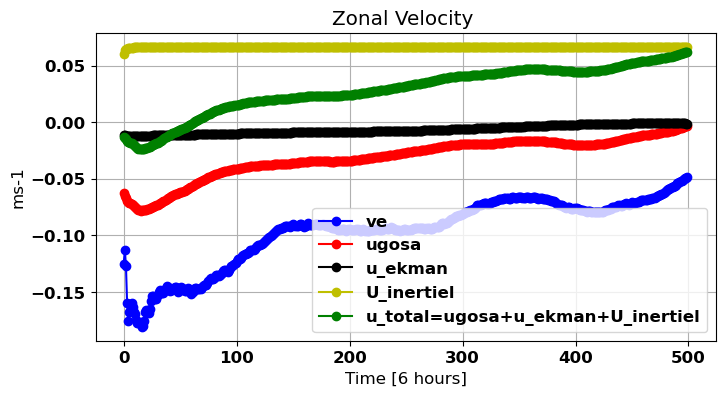

In [34]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1,marker='o', linestyle='-', color='blue',label='ve')
plt.plot(filtered_values_5,marker='o', linestyle='-', color='red',label='ugosa')
plt.plot(filtered_values_7,marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(filtered_values_9,marker='o', linestyle='-', color='y',label='U_inertiel')
plt.plot(filtered_values_2,marker='o', linestyle='-', color='g',label='u_total=ugosa+u_ekman+U_inertiel')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('ms-1')
plt.grid(True)
plt.legend()
plt.savefig("fig31 mode.png")
plt.show()

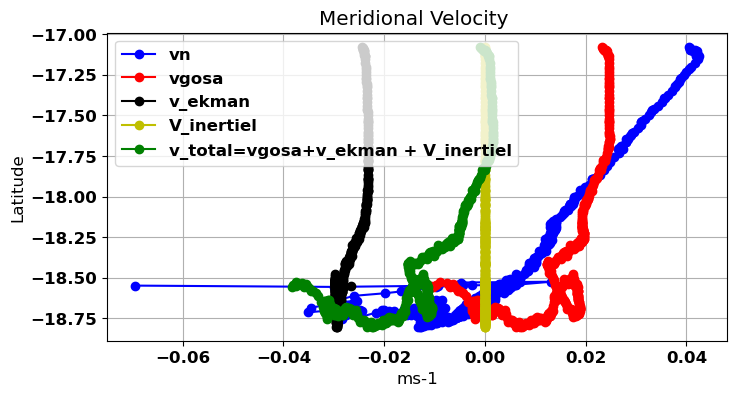

In [31]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3, df_1['latitude'],marker='o', linestyle='-', color='blue',label='vn')
plt.plot(filtered_values_6, df_1['latitude'],marker='o', linestyle='-', color='red',label='vgosa')
plt.plot(filtered_values_8, df_1['latitude'],marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(filtered_values_10, df_1['latitude'],marker='o', linestyle='-', color='y',label='V_inertiel')

plt.plot(filtered_values_4, df_1['latitude'],marker='o', linestyle='-', color='g',label='v_total=vgosa+v_ekman + V_inertiel')

plt.title('Meridional Velocity ')
plt.xlabel('ms-1')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.savefig("fig32 mode.png")
plt.show()

### Time series

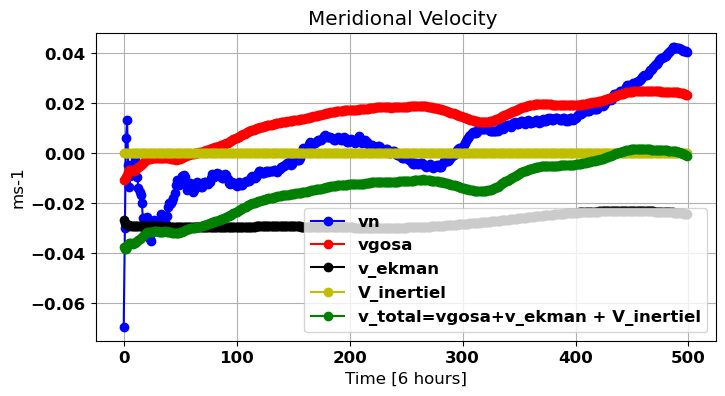

In [37]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3,marker='o', linestyle='-', color='blue',label='vn')
plt.plot(filtered_values_6,marker='o', linestyle='-', color='red',label='vgosa')
plt.plot(filtered_values_8,marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(filtered_values_10,marker='o', linestyle='-', color='y',label='V_inertiel')

plt.plot(filtered_values_4,marker='o', linestyle='-', color='g',label='v_total=vgosa+v_ekman + V_inertiel')

plt.title('Meridional Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('ms-1')
plt.grid(True)
plt.legend()
plt.savefig("fig33 mode.png")
plt.show()

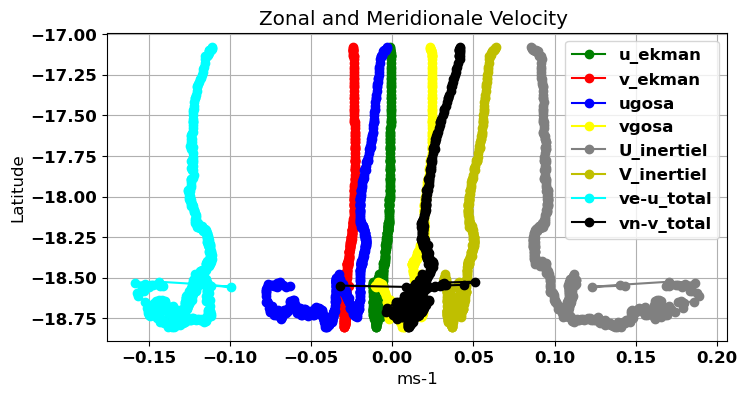

In [45]:
 # Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_7, df_1['latitude'],marker='o', linestyle='-', color='green',label='u_ekman')
plt.plot(filtered_values_8, df_1['latitude'],marker='o', linestyle='-', color='red',label='v_ekman')
plt.plot(filtered_values_5, df_1['latitude'],marker='o', linestyle='-', color='blue',label='ugosa')
plt.plot(filtered_values_6, df_1['latitude'],marker='o', linestyle='-', color='yellow',label='vgosa')
plt.plot(filtered_values_9, df_1['latitude'],marker='o', linestyle='-', color='gray',label='U_inertiel')
plt.plot(filtered_values_10, df_1['latitude'],marker='o', linestyle='-', color='y',label='V_inertiel')


list1=filtered_values_1
list2=filtered_values_2
result = [x - y for x, y in zip(list1, list2)]
plt.plot(result, df_1['latitude'],marker='o', linestyle='-', color='CYAN',label='ve-u_total')

list3=filtered_values_3
list4=filtered_values_4
result2 = [x - y for x, y in zip(list3, list4)]
plt.plot(result2, df_1['latitude'],marker='o', linestyle='-', color='black',label='vn-v_total')

plt.title('Zonal and Meridionale Velocity ')
plt.xlabel('ms-1')
plt.ylabel('Latitude')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.savefig("fig34 mode.png")
plt.show()

### Time series

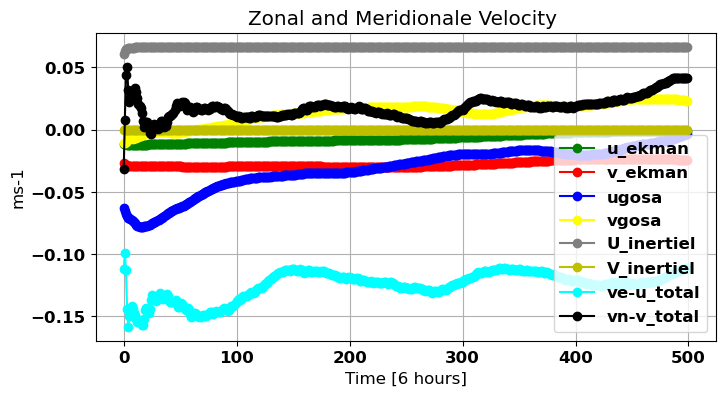

In [39]:
 # Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_7,marker='o', linestyle='-', color='green',label='u_ekman')
plt.plot(filtered_values_8,marker='o', linestyle='-', color='red',label='v_ekman')
plt.plot(filtered_values_5,marker='o', linestyle='-', color='blue',label='ugosa')
plt.plot(filtered_values_6,marker='o', linestyle='-', color='yellow',label='vgosa')
plt.plot(filtered_values_9,marker='o', linestyle='-', color='gray',label='U_inertiel')
plt.plot(filtered_values_10,marker='o', linestyle='-', color='y',label='V_inertiel')


list1=filtered_values_1
list2=filtered_values_2
result = [x - y for x, y in zip(list1, list2)]
plt.plot(result,marker='o', linestyle='-', color='CYAN',label='ve-u_total')

list3=filtered_values_3
list4=filtered_values_4
result2 = [x - y for x, y in zip(list3, list4)]
plt.plot(result2,marker='o', linestyle='-', color='black',label='vn-v_total')

plt.title('Zonal and Meridionale Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('ms-1')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.savefig("fig35 mode.png")
plt.show()

## Magnitude of Currents

In [40]:
def calculate_magnitude(v_x, v_y):
    """
    Calculate the magnitude of vector v from its components v_x and v_y.
    """
    return np.sqrt(v_x*v_x + v_y*v_y)

# Calculate the magnitude of the wind velocity vector
v_x = bouees_courant_u
v_y = bouees_courant_v
magnitude_vevn= calculate_magnitude(v_x, v_y)

v_x = dF['u_total']
v_y = dF['v_total']
magnitude_uv_total= calculate_magnitude(v_x, v_y)

### The use of Kalman filter for smoothing magnitude_vevn and magnitude_uv_total

### Case of $magnitude_vevn$

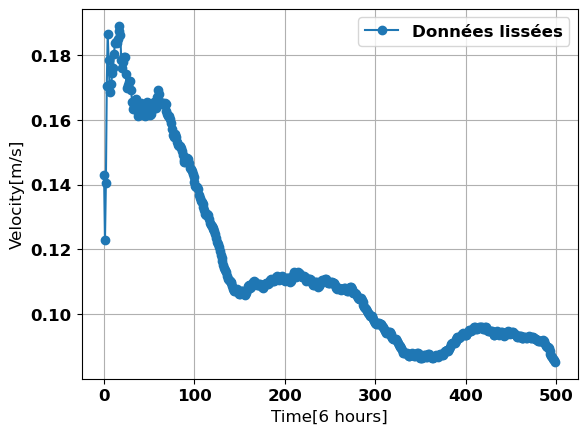

In [41]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  magnitude_vevn

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_9 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_9.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_9, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of $magnitude_uv_total$

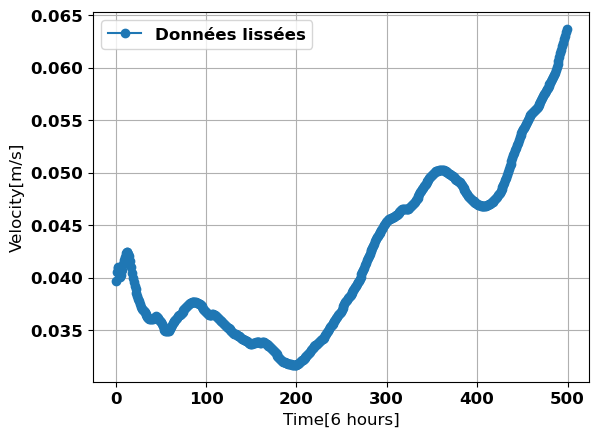

In [42]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle = magnitude_uv_total

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_10 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_10.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_10, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

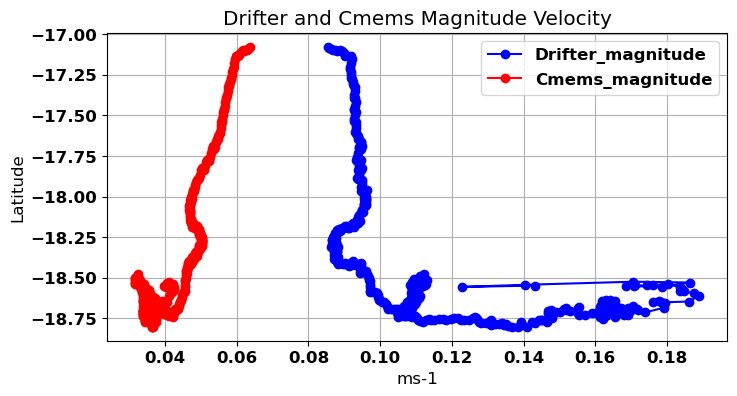

In [44]:
 # Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_9, df_1['latitude'],marker='o', linestyle='-', color='blue',label='Drifter_magnitude')
plt.plot(filtered_values_10, df_1['latitude'],marker='o', linestyle='-', color='red',label='Cmems_magnitude')
 
plt.title('Drifter and Cmems Magnitude Velocity')
plt.xlabel('ms-1')
plt.ylabel('Latitude')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.savefig("fig36 mode.png")
plt.show()

### Time series

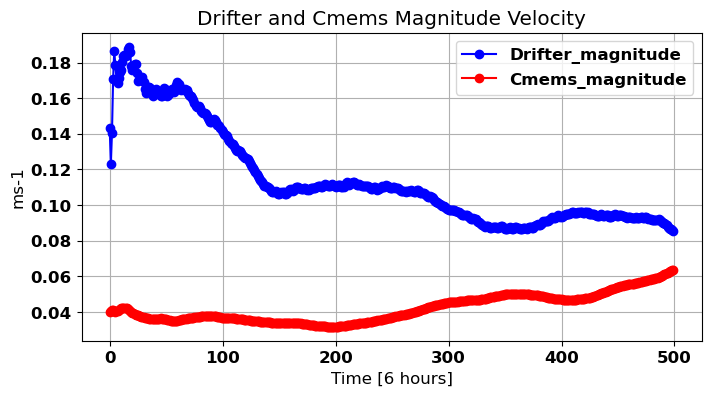

In [46]:
 # Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_9,marker='o', linestyle='-', color='blue',label='Drifter_magnitude')
plt.plot(filtered_values_10,marker='o', linestyle='-', color='red',label='Cmems_magnitude')
 
plt.title('Drifter and Cmems Magnitude Velocity')
plt.xlabel('Time [6 hours]')
plt.ylabel('ms-1')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.savefig("fig37 mode.png")
plt.show()

## Conclusion
- The geostrophic current dominates both the zonal and meridional directions. The Ekman current calculated from NOAA wind data is dominated by the meridional component. The magnitude of the total zonal drifter current is much higher compared to that of the satellite, while the meridional components are approximately the same.
- By adding the Ekman current to the zonal and meridional geostrophic currents from CMEMS satellites, we observe a clear improvement in the satellite current, which tends to approach more and more closely to that of our drifters.
-  The magnitudes of Drifter and Cmems velocities approximately describe the same variations according to latitudes. However, we note a difference of 0.75 between the two curves.
 